In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, ensemble, linear_model, neighbors, naive_bayes
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve 
from sklearn.metrics import confusion_matrix, precision_recall_curve,f1_score, fbeta_score, log_loss
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn import svm, metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
import pickle

In [3]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [4]:
df = pd.read_csv('proj3_data.csv', index_col=0)

In [5]:
df = df[df.population != 0]

In [6]:
# making a copy of the dataframe to separate out my new features (later)
new_df = df.copy()

## Target distribution

In [140]:
df.at_risk.describe()

count    3141.000000
mean        0.044890
std         0.207096
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: at_risk, dtype: float64

# Exploratory Data Analysis

## Grouping by target and different features

In [17]:
df.groupby('at_risk').mean()

,countyfips,population,ppl_popdensity,county_beds,total_cases,total_deaths,days_since_case1,days_since_death1,county_hospitalizations,county_testing_rate,cases_wk_before,deaths_wk_before,pcnt_inc_wk10,pcnt_inc_wk11,pcnt_inc_wk12,inc_pov_rate,inc_med_hh,inc_per_cap,jobs_serv,jobs_manu,jobs_agro,jobs_unem,jobs_const,jobs_trans,ppl_ov65_pct,ppl_un18_pct,ppl_nohs_pct,ppl_college_pct,ppl_wht_pct,ppl_hisp_pct,ppl_bl_pct
at_risk,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,30381.378000,101087.088667,250.860403,244.568000,255.035000,13.764333,24.211667,7.395667,6.711198,0.113188,62.179333,4.811000,1.297119,0.628945,0.384084,15.395467,50944.566333,26007.602333,42.769148,12.178532,5.240862,4.131733,7.25836,5.542829,12.388741,23.387170,13.774713,21.079246,78.690117,8.148817,8.513463
1,30541.042553,177150.148936,436.594752,431.858156,223.042553,7.787234,32.092199,13.382979,7.005625,0.021506,85.212766,3.574468,2.036489,1.444280,1.367225,15.011348,54196.127660,26579.496454,44.886134,14.796628,2.503240,4.167376,6.64594,4.763898,11.089720,24.288298,14.547407,23.966425,70.270355,11.247234,13.735248


Make a table for the presentation highlighting the main differences.

## Visualizations

Based on subject area knowledge, making a DataFrame of what I think may be the most impactful features, then looking at a pairplot to see if I am correct.

In [6]:
# looking at all the covid/medical related features

covid_df = df[['total_cases', 'days_since_case1', 'total_deaths', 'days_since_death1', 'county_beds', 
              'county_hospitalizations', 'county_testing_rate', 'at_risk']]

In [ ]:
sns.pairplot(covid_df, hue='at_risk');

It looks like both totals and both days since case/death 1 could have some separating qualities. Perhaps county beds too.

In [7]:
# looking at all income related features

income_df = df[['inc_pov_rate', 'inc_med_hh', 'inc_per_cap', 'at_risk']]

In [ ]:
sns.pairplot(income_df, hue='at_risk');

Not much going on here unfortunately

In [8]:
# looking at all job related features

jobs_df = df[['jobs_serv', 'jobs_manu', 'jobs_trans', 'jobs_agro', 'jobs_unem', 'jobs_const', 'at_risk']]

In [ ]:
sns.pairplot(jobs_df, hue='at_risk');

Maybe a bit of separated from jobs in argriculture

In [9]:
# looking at all people related features

people_df = df[['population', 'ppl_popdensity', 'ppl_ov65_pct', 'ppl_un18_pct', 'ppl_wht_pct',
               'ppl_hisp_pct', 'ppl_bl_pct', 'at_risk']]

In [ ]:
ns.pairplot(people_df, hue='at_risk');

Looks like population density and percentage of black people have some good separating qualities ( as well as percentage of white population too).

In [10]:
# looking at all education related features

ed_df = df[['ppl_nohs_pct', 'ppl_college_pct', 'at_risk']]

In [ ]:
sns.pairplot(ed_df, hue='at_risk');

# Baseline Models

In [19]:
X, y = df.iloc[:, 3:-1], df.at_risk

X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42)

In [8]:
log = LogisticRegression(solver= 'liblinear')
knn = KNeighborsClassifier()
svc_linear = SVC(probability=True,)
svc_rbf = SVC(probability=True)
nbB = BernoulliNB()
nbG = GaussianNB()
rfc = RandomForestClassifier()

In [9]:
baseline_models = {'Logistic':log, 'KNN': knn, 'SVC Linear': svc_linear, 'SVC rbf':svc_rbf, 
          'NB Bernoulli': nbB, 'NB Gauss ':nbG, 'Random Forest':rfc}

## Hard predictions, no CV

In [10]:
def score_models(X, y, models, random_state):
    
    '''Takes in dataframe features and target, splits the data into train, test, val, then fits the model and
    returns the various scores of the model.
    
    input:
            X: Features from DataFrame
            y: Target from DataFrame
            models: dictionary of models to score
    output: accuracy, precision, recall, f1 and ROC AUC of models'''
    
    X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=random_state)
    
    for key, model in models.items():
    
        model.fit(X_train, y_train)
        pred = model.predict(X_val)

        print(str(key))
        print('accuracy:', accuracy_score(y_val, pred))
        print('precision:', precision_score(y_val, pred))
        print('recall:', recall_score(y_val, pred))
        print('f1:', f1_score(y_val, pred))
        print('ROC AUC', roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))
        print('\n')
    

In [20]:
score_models(X, y, baseline_models, 42)

Logistic
accuracy: 0.9463220675944334
precision: 0.6666666666666666
recall: 0.07142857142857142
f1: 0.12903225806451613
ROC AUC 0.7877443609022556


KNN
accuracy: 0.9443339960238568
precision: 0.5
recall: 0.03571428571428571
f1: 0.06666666666666667
ROC AUC 0.6315037593984962


SVC Linear
accuracy: 0.9443339960238568
precision: 0.0
recall: 0.0
f1: 0.0
ROC AUC 0.6689473684210527


SVC rbf
accuracy: 0.9443339960238568
precision: 0.0
recall: 0.0
f1: 0.0
ROC AUC 0.331203007518797


NB Bernoulli
accuracy: 0.7753479125248509
precision: 0.13675213675213677
recall: 0.5714285714285714


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1: 0.22068965517241382
ROC AUC 0.7675187969924813


NB Gauss 
accuracy: 0.10934393638170974
precision: 0.04741379310344827
recall: 0.7857142857142857
f1: 0.08943089430894308
ROC AUC 0.5898496240601504


Random Forest
accuracy: 0.9502982107355865
precision: 0.7142857142857143
recall: 0.17857142857142858
f1: 0.2857142857142857
ROC AUC 0.8667669172932331




In [93]:
def make_confusion_matrix(X, y, model, threshold, random_state):
    
    X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)
    
    model.fit(X, y)
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    print('F1 score:', f1_score(y_test, y_predict))
    covid_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(covid_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=["Won't Increase", 'Continue to Increase'],
           yticklabels=["Won't Increase", 'Continue to Increase']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

F1 score: 0.08183306055646482


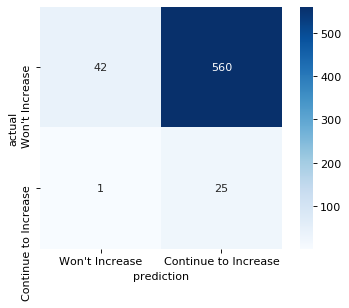

In [22]:
# using the best model from above, Naive Bayes Gauss

make_confusion_matrix(X, y, nbG, 0.5, 42)

Pretty bad! My goal will to try and improve this initial "best model."

# Dummy Variables and Basic Feature Engineering

## Coastal Counties
Instead of a straight up dummy variable for the county, I thought it would be interesting to have a column that determines if the county is coastal or not (since a lot of coastal states have been affected)

In [23]:
coastal_counties = pd.read_excel('coastal_counties.xlsx', header=None, names=['county_name'])

In [24]:
new_df['coastal'] = 0
df['coastal'] = 0

In [25]:
for index, county in enumerate(df['county_name']):
    if county in list(coastal_counties.county_name.values):
        df['coastal'].loc[index] = 1


for index, county in enumerate(new_df['county_name']):
    if county in list(coastal_counties.county_name.values):
        new_df['coastal'].loc[index] = 1


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
# set and apply new column order

col_ord = ['countyfips', 'county_name', 'state', 'coastal', 'population', 'ppl_popdensity',
       'county_beds', 'total_cases', 'total_deaths', 'days_since_case1',
       'days_since_death1', 'county_hospitalizations', 'county_testing_rate',
       'cases_wk_before', 'deaths_wk_before', 'pcnt_inc_wk10', 'pcnt_inc_wk11',
       'pcnt_inc_wk12', 'inc_pov_rate', 'inc_med_hh', 'inc_per_cap',
       'jobs_serv', 'jobs_manu', 'jobs_agro', 'jobs_unem', 'jobs_const',
       'jobs_trans', 'ppl_ov65_pct', 'ppl_un18_pct', 'ppl_nohs_pct',
       'ppl_college_pct', 'ppl_wht_pct', 'ppl_hisp_pct', 'ppl_bl_pct',
       'at_risk']

In [28]:
new_df = new_df[col_ord]
df = df[col_ord]

## States by region
Instead of dummying all 50 states I will separate them into different regions of the United States (North East, West, etc.)

In [29]:
regions = {'Alaska': 'Other',
        'Alabama': 'South',
        'Arkansas': 'South',
        'Arizona': 'West',
        'California': 'West',
        'Colorado': 'West',
        'Connecticut': 'Northeast',
        'District of Columbia': 'Northeast',
        'Delaware': 'Northeast',
        'Florida': 'South',
        'Georgia': 'South',
        'Hawaii': 'Other',
        'Iowa': 'Midwest',
        'Idaho': 'West',
        'Illinois': 'Midwest',
        'Indiana': 'Midwest',
        'Kansas': 'Midwest',
        'Kentucky': 'South',
        'Louisiana': 'South',
        'Massachusetts': 'Northeast',
        'Maryland': 'Northeast',
        'Maine': 'Northeast',
        'Michigan': 'West',
        'Minnesota': 'Midwest',
        'Missouri': 'Midwest',
        'Mississippi': 'South',
        'Montana': 'West',
        'North Carolina': 'South',
        'North Dakota': 'Midwest',
        'Nebraska': 'West',
        'New Hampshire': 'Northeast',
        'New Jersey': 'Northeast',
        'New Mexico': 'West',
        'Nevada': 'West',
        'New York': 'Northeast',
        'Ohio': 'Midwest',
        'Oklahoma': 'South',
        'Oregon': 'West',
        'Pennsylvania': 'Northeast',
        'Rhode Island': 'Northeast',
        'South Carolina': 'South',
        'South Dakota': 'Midwest',
        'Tennessee': 'South',
        'Texas': 'South',
        'Utah': 'West',
        'Virginia': 'South',
        'Vermont': 'Northeast',
        'Washington': 'West',
        'Wisconsin': 'Midwest',
        'West Virginia': 'South',
        'Wyoming': 'West'}

In [30]:
df['region'] = df.state
new_df['region'] = df.state

In [31]:
df.region = df.region.apply(lambda x: regions[x])
new_df.region = new_df.region.apply(lambda x: regions[x])

In [32]:
col_ord = ['countyfips', 'county_name', 'state', 'region', 'coastal', 'population',
       'ppl_popdensity', 'county_beds', 'total_cases', 'total_deaths',
       'days_since_case1', 'days_since_death1', 'county_hospitalizations',
       'county_testing_rate', 'cases_wk_before', 'deaths_wk_before',
       'pcnt_inc_wk10', 'pcnt_inc_wk11', 'pcnt_inc_wk12', 'inc_pov_rate',
       'inc_med_hh', 'inc_per_cap', 'jobs_serv', 'jobs_manu', 'jobs_agro',
       'jobs_unem', 'jobs_const', 'jobs_trans', 'ppl_ov65_pct', 'ppl_un18_pct',
       'ppl_nohs_pct', 'ppl_college_pct', 'ppl_wht_pct', 'ppl_hisp_pct',
       'ppl_bl_pct', 'at_risk']

In [33]:
df = df[col_ord]
new_df = new_df[col_ord]

## Regional Dummy Variables

In [34]:
df = pd.concat((df, pd.get_dummies(df.region, drop_first=True)), axis=1)
new_df = pd.concat((new_df, pd.get_dummies(new_df.region, drop_first=True)), axis=1)

In [35]:
col_ord = ['countyfips', 'county_name', 'state', 'region', 'Northeast', 'Other', 'South', 'West', 
        'coastal', 'population',
       'ppl_popdensity', 'county_beds', 'total_cases', 'total_deaths',
       'days_since_case1', 'days_since_death1', 'county_hospitalizations',
       'county_testing_rate', 'cases_wk_before', 'deaths_wk_before',
       'pcnt_inc_wk10', 'pcnt_inc_wk11', 'pcnt_inc_wk12', 'inc_pov_rate',
       'inc_med_hh', 'inc_per_cap', 'jobs_serv', 'jobs_manu', 'jobs_agro',
       'jobs_unem', 'jobs_const', 'jobs_trans', 'ppl_ov65_pct', 'ppl_un18_pct',
       'ppl_nohs_pct', 'ppl_college_pct', 'ppl_wht_pct', 'ppl_hisp_pct',
       'ppl_bl_pct', 'at_risk']

In [36]:
df = df[col_ord]
new_df = new_df[col_ord]

# Splitting Data

### Original dataframe

In [37]:
X, y = df.iloc[:, 4:-1], df.at_risk

In [38]:
X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42)

In [39]:
# mask (if needed)
train_df = X_train.copy()
train_df['at_risk'] = y_train

# at risk mask
at_risk_mask  = (train_df['at_risk'] == 1).values

# Dummy Model

In [40]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [41]:
dummy_model.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [42]:
dummy_model.score(X_val, y_val)

0.9585987261146497

Woohoo! Awesome... oh wait. No, I shouldn't be excited about this.

# Models Overview
Getting a better idea of which models will be the best for this dataset

In [43]:
# pipelines in order to scale data
log_pipe = make_pipeline(StandardScaler(), LogisticRegression(solver= 'liblinear'))
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
svc_linear_pipe = make_pipeline(StandardScaler(), SVC(probability=True,kernel='linear'))
svc_rbf_pipe = make_pipeline(StandardScaler(), SVC(probability=True))

# models that do not require scalling
nbB = BernoulliNB()
nbG = GaussianNB()
rfc = RandomForestClassifier()

In [44]:
models = {'Logistic':log_pipe, 'KNN': knn_pipe, 'SVC Linear': svc_linear_pipe, 'SVC rbf':svc_rbf_pipe, 
          'NB Bernoulli': nbB, 'NB Gauss ':nbG, 'Random Forest':rfc}

## Hard predictions, no CV

### On original dataframe

In [46]:
score_models(X, y, models, 42)

Logistic
accuracy: 0.9423459244532804
precision: 0.3333333333333333
recall: 0.03571428571428571
f1: 0.06451612903225806
ROC AUC 0.7661654135338345


KNN
accuracy: 0.9383697813121272
precision: 0.0
recall: 0.0
f1: 0.0
ROC AUC 0.6517669172932331


SVC Linear
accuracy: 0.9443339960238568
precision: 0.0
recall: 0.0
f1: 0.0
ROC AUC 0.6858646616541353




/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC rbf
accuracy: 0.9443339960238568
precision: 0.0
recall: 0.0
f1: 0.0
ROC AUC 0.7739097744360902


NB Bernoulli
accuracy: 0.7972166998011928
precision: 0.13725490196078433
recall: 0.5
f1: 0.21538461538461542
ROC AUC 0.7619172932330827


NB Gauss 
accuracy: 0.10934393638170974
precision: 0.04741379310344827
recall: 0.7857142857142857
f1: 0.08943089430894308
ROC AUC 0.5898496240601504




/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest
accuracy: 0.94831013916501
precision: 0.6666666666666666
recall: 0.14285714285714285
f1: 0.23529411764705882
ROC AUC 0.878796992481203




## ROC curve and AUC for each model 

### On original dataframe

In [47]:
def ROC_AUC(X, y, models, random_state):
    '''Takes in features and target from a dataframe and models to fit the data to and returns
    the ROC curve for each model.
    
    input:
            X: Features from DataFrame
            y: Target from DataFrame
            models: dictionary of models to score
    output: ROC Curve for each model'''
    
    X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42)
    
    fig, ax = plt.subplots(figsize=(10,6))

    for key, model in models.items():
        model.fit(X_train, y_train)
        fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])

        plt.plot(fpr, tpr,lw=2)
        print(str(key) + " ROC AUC score = ", roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))

        plt.plot([0,1],[0,1],c='violet',ls='--')
        plt.xlim([-0.05,1.05])
        plt.ylim([-0.05,1.05])

        plt.legend(labels=['Logistic', 'KNN', 'SVM Linear', 'SVM RBF', 'NB Bernoulli',
                           'NB Gauss', 'Random Forest'])

        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC Curve');  

Logistic ROC AUC score =  0.7661654135338345
KNN ROC AUC score =  0.6517669172932331
SVC Linear ROC AUC score =  0.6858646616541353
SVC rbf ROC AUC score =  0.773609022556391
NB Bernoulli ROC AUC score =  0.7619172932330827
NB Gauss  ROC AUC score =  0.5898496240601504
Random Forest ROC AUC score =  0.8765037593984962


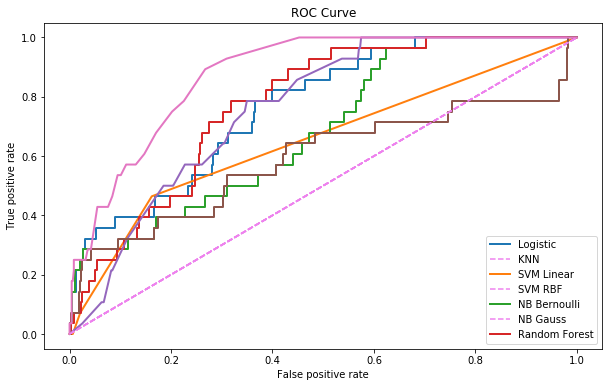

In [48]:
ROC_AUC(X, y, models, 42)

## CV

### On original dataframe

In [49]:
def cv_scores(X, y, models, scores, folds):
    '''Takes in features and target from a dataframe, a list of models and a list of scores, then runs
    cv on each of the models and returns the scores.
    input:
        X: features
        y: target
        models: list of models
        scores: desires model scores
        folds: number of k folds
    output: desired scores of each model'''
    
    for key, model in models.items():
        print(str(key))
        for score in scores:
            print(score, cross_val_score(model, X, y, cv=folds, scoring=score).mean())
    
    

In [50]:
scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_scores(X, y, models, scores, 10)

Logistic
accuracy 0.9518291911718209


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification

precision 0.18333333333333332
recall 0.026515151515151512
f1 0.04505494505494506
roc_auc 0.8357792754955412
KNN
accuracy 0.9534307215582117


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision 0.25
recall 0.02727272727272727
f1 0.048717948717948725
roc_auc 0.657341953795275
SVC Linear
accuracy 0.9550180231455133


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification

precision 0.0
recall 0.0
f1 0.0
roc_auc 0.7550460277460801
SVC rbf
accuracy 0.9550180231455133


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification

precision 0.0
recall 0.0
f1 0.0
roc_auc 0.8240044931532904
NB Bernoulli
accuracy 0.7639537089736294
precision 0.09341692570140495
recall 0.48636363636363633
f1 0.15652871614860678
roc_auc 0.7467009002155447
NB Gauss 
accuracy 0.08838139505470183
precision 0.04437453733648662
recall 0.9371212121212121
f1 0.08473126285158385
roc_auc 0.6939651219306031
Random Forest
accuracy 0.9589989249351799


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision 0.775
recall 0.11590909090909092
f1 0.18260073260073262
roc_auc 0.859270595600355


Also very bad. We'll have to engineer some new features and address the class imbalance. NB Gauss still has the highest F1 score.

# Adressing class imbalance

## Function to handle CV with over/under sampling

In [54]:
def cv_sampling(X, y, models, folds, sampler):
    '''Takes in features, target, list of models and oversampling/undersamping object and runs cv.
    
    input:
        X: features
        y: target
        models: list of models
        folds: number of k folds
        sampler: oversample, smote or undersample
    output:
        F1 score and AUC for each model'''
    
    kf = KFold(n_splits=folds, shuffle=True)
    
    for name, model in models.items():
    
        f1s = []
        roc_aucs = []
        X, y = np.array(X), np.array(y)

        for train_ind, val_ind in kf.split(X,y):

            # training and validation sets
            X_train_cv, y_train_cv = X[train_ind], y[train_ind]
            X_val, y_val = X[val_ind], y[val_ind] 

            # resampling the training data
            X_resampled_cv, y_resampled_cv = sampler.fit_sample(X_train_cv,y_train_cv)

            # fitting the model on the resampled data
            model.fit(X_resampled_cv, y_resampled_cv)

            # prediction on the validation set
            pred = model.predict(X_val)

    
            f1s.append(f1_score(y_val, pred))
            roc_aucs.append(roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))

        print(str(name)) 
        print('f1', np.mean(f1s))
        print('ROC AUC', np.mean(roc_aucs))
    
    

## Manual CV on the oversampled data

In [ ]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)

In [55]:
cv_sampling(X, y, models, 10, RandomOverSampler(random_state=0))

Logistic
f1 0.2423309418472721
ROC AUC 0.8650918148119429
KNN
f1 0.20133826787277828
ROC AUC 0.6629031911059122
SVC Linear
f1 0.23714063596443494
ROC AUC 0.8660808338936283
SVC rbf
f1 0.24830543545579573
ROC AUC 0.8117964187865304
NB Bernoulli
f1 0.1598981509298411
ROC AUC 0.7512269751703564
NB Gauss 
f1 0.08538381956697833
ROC AUC 0.6762244934058118
Random Forest
f1 0.1946591970121382
ROC AUC 0.8640436543995962


## SMOTE

In [59]:
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

In [56]:
cv_sampling(X, y, models, 10, SMOTE(random_state=42))

Logistic
f1 0.2578920028088471
ROC AUC 0.8700903899450502
KNN
f1 0.1989961844042422
ROC AUC 0.716867208337454
SVC Linear
f1 0.2599497337461528
ROC AUC 0.8780534387613453
SVC rbf
f1 0.26275539571797457
ROC AUC 0.8038202117664035
NB Bernoulli
f1 0.15671151419445292
ROC AUC 0.7409652305485472
NB Gauss 
f1 0.08515936564114236
ROC AUC 0.6669010197788766
Random Forest
f1 0.31400523507940387
ROC AUC 0.8833483980261526


## Under Sampling

In [179]:
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X_train, y_train)

In [57]:
cv_sampling(X, y, models, 10, RandomUnderSampler(random_state=42))

Logistic
f1 0.21453662547092506
ROC AUC 0.8314667530674731
KNN
f1 0.14992028308807762
ROC AUC 0.7334935344993716
SVC Linear
f1 0.20704244554138765
ROC AUC 0.8216317725371438
SVC rbf
f1 0.2064115661604104
ROC AUC 0.8299194758697842
NB Bernoulli
f1 0.15652949334594768
ROC AUC 0.75379435468837
NB Gauss 
f1 0.11838503513512422
ROC AUC 0.7152748508487595
Random Forest
f1 0.22445237683028507
ROC AUC 0.8731064807454908


Smote seems to work the best (by a small amount) for handling class imbalance.

# Threshold Adjustment

In [60]:
# loop through the models and find the optimal threshold for each

for key, model in models.items():
    model.fit(X_smoted, y_smoted)

    thresh_ps = np.linspace(.10,.90,1000)
    model_val_probs = model.predict_proba(X_val)[:,1] # positive class probs, same basic logistic model we fit in section 2 

    f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        f1_scores.append(f1_score(y_val, model_val_labels))    
        prec_scores.append(precision_score(y_val, model_val_labels, zero_division=1))
        rec_scores.append(recall_score(y_val, model_val_labels))
        acc_scores.append(accuracy_score(y_val, model_val_labels))

    best_recall_score = np.max(rec_scores)
    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]
    
    print(str(key) + ' best F1 score %.3f at prob decision threshold >= %.3f' 
          % (best_f1_score, best_thresh_p))

Logistic best F1 score 0.328 at prob decision threshold >= 0.811
KNN best F1 score 0.159 at prob decision threshold >= 0.200
SVC Linear best F1 score 0.348 at prob decision threshold >= 0.896
SVC rbf best F1 score 0.278 at prob decision threshold >= 0.507
NB Bernoulli best F1 score 0.161 at prob decision threshold >= 0.806
NB Gauss  best F1 score 0.080 at prob decision threshold >= 0.596
Random Forest best F1 score 0.367 at prob decision threshold >= 0.440


## Models with the most potential:
- Random Forest
- SVC RBF
- Logistic
- SVC Linear

In [61]:
best_models = {'Logistic':log_pipe,'SVC Linear': svc_linear_pipe, 'SVC rbf':svc_rbf_pipe, 'Random Forest':rfc}

# More Feature Engineering

## Percentage population non-white
Instead of just looking at percentage white, hispanic, black, I will also include a column for population of people in a county who are non-white.

In [62]:
new_df['ppl_non_wht'] = 100 - new_df.ppl_wht_pct

In [63]:
# setting a applying new column order

col_ord = ['countyfips', 'county_name', 'state', 'region', 'Northeast', 'Other',
       'South', 'West', 'coastal', 'population', 'ppl_popdensity',
       'county_beds', 'total_cases', 'total_deaths', 'days_since_case1',
       'days_since_death1', 'county_hospitalizations', 'county_testing_rate',
       'cases_wk_before', 'deaths_wk_before', 'pcnt_inc_wk10', 'pcnt_inc_wk11',
       'pcnt_inc_wk12', 'inc_pov_rate', 'inc_med_hh', 'inc_per_cap',
       'jobs_serv', 'jobs_manu', 'jobs_agro', 'jobs_unem', 'jobs_const',
       'jobs_trans', 'ppl_ov65_pct', 'ppl_un18_pct', 'ppl_nohs_pct',
       'ppl_college_pct', 'ppl_wht_pct', 'ppl_hisp_pct', 'ppl_bl_pct', 'ppl_non_wht',
       'at_risk']

new_df = new_df[col_ord]

## Cases and Deaths per capita
Instead of looking at totals for number of cases and deaths due to covid-19 per county, it may be better to adjust for population size. Same thing for hospital beds.

In [64]:
# creating columns for total cases and deaths per 100,000 people in each county. 
# This could be a better indicator comparing numbers across county.

new_df['tot_cases_percap'] = (new_df.total_cases / new_df.population) * 100000
new_df['tot_deaths_percap'] = (new_df.total_deaths / new_df.population) * 100000

In [65]:
# rouding up to the nearest integer

new_df.tot_cases_percap = new_df.tot_cases_percap.apply(np.ceil)
new_df.tot_deaths_percap = new_df.tot_deaths_percap.apply(np.ceil)

In [66]:
# setting a applying new col order
col_ord = ['countyfips', 'county_name', 'state', 'region', 'Northeast', 'Other',
       'South', 'West', 'coastal', 'population', 'ppl_popdensity',
       'county_beds', 'total_cases', 'total_deaths', 'tot_cases_percap', 'tot_deaths_percap', 'days_since_case1',
       'days_since_death1', 'county_hospitalizations', 'county_testing_rate',
       'cases_wk_before', 'deaths_wk_before', 'pcnt_inc_wk10', 'pcnt_inc_wk11',
       'pcnt_inc_wk12', 'inc_pov_rate', 'inc_med_hh', 'inc_per_cap',
       'jobs_serv', 'jobs_manu', 'jobs_agro', 'jobs_unem', 'jobs_const',
       'jobs_trans', 'ppl_ov65_pct', 'ppl_un18_pct', 'ppl_nohs_pct',
       'ppl_college_pct', 'ppl_wht_pct', 'ppl_hisp_pct', 'ppl_bl_pct',
       'ppl_non_wht', 'at_risk']

new_df = new_df[col_ord]

## Other new features to consider

### At risk groups

In [67]:
new_df['pct_at_risk_group'] = new_df.ppl_bl_pct + new_df.ppl_hisp_pct + new_df.ppl_ov65_pct

In [68]:
new_df['cases_deaths'] = new_df.total_cases + new_df.total_deaths

In [69]:
new_df['cases_per_day'] = new_df.tot_cases_percap / new_df.days_since_case1

In [70]:
col_ord = ['countyfips', 'county_name', 'state', 'region', 'Northeast', 'Other',
       'South', 'West', 'coastal', 'population', 'ppl_popdensity',
       'county_beds', 'total_cases', 'total_deaths', 'tot_cases_percap',
       'tot_deaths_percap', 'days_since_case1', 'days_since_death1',
       'county_hospitalizations', 'county_testing_rate', 'cases_wk_before',
       'deaths_wk_before', 'pcnt_inc_wk10', 'pcnt_inc_wk11', 'pcnt_inc_wk12',
       'inc_pov_rate', 'inc_med_hh', 'inc_per_cap', 'jobs_serv', 'jobs_manu',
       'jobs_agro', 'jobs_unem', 'jobs_const', 'jobs_trans', 'ppl_ov65_pct',
       'ppl_un18_pct', 'ppl_nohs_pct', 'ppl_college_pct', 'ppl_wht_pct',
       'ppl_hisp_pct', 'ppl_bl_pct', 'ppl_non_wht',
       'pct_at_risk_group', 'cases_deaths', 'cases_per_day', 'at_risk']

In [71]:
new_df = new_df[col_ord]

In [72]:
new_df.cases_per_day = new_df.cases_per_day.fillna(new_df.cases_per_day.mean())

In [73]:
new_df.pcnt_inc_wk12.replace(np.inf, new_df.pcnt_inc_wk12.median(), inplace=True)
new_df.pcnt_inc_wk12.replace(np.nan, 0, inplace=True)


## Splitting with new features

In [74]:
X_new, y_new = new_df.iloc[:, 4:-1], new_df.at_risk

X_new, X_test_new, y_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2, random_state=42)

X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_new, y_new, test_size=.25, random_state=42)

In [75]:
cv_sampling(X_new, y_new, best_models, 10, SMOTE(random_state=42))

Logistic
f1 0.2513254499540756
ROC AUC 0.861491137883206
SVC Linear
f1 0.26757413367208743
ROC AUC 0.864141132344401
SVC rbf
f1 0.2648513726175905
ROC AUC 0.7953501520281856
Random Forest
f1 0.3020871731921976
ROC AUC 0.8791413387459042


It looks like the F1 scores went slightly down.

## Threshold Adjustment
Let's see if the model's potential goes up with the new features added in.

In [76]:
X_new_smoted, y_new_smoted = SMOTE(random_state=42).fit_sample(X_train_new,y_train_new)

In [77]:
# loop through the best models and find the optimal threshold for each

for key, model in best_models.items():
    model.fit(X_new_smoted, y_new_smoted)

    thresh_ps = np.linspace(.10,.90,1000)
    model_val_probs = model.predict_proba(X_val_new)[:,1]

    f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        f1_scores.append(f1_score(y_val_new, model_val_labels))    
        prec_scores.append(precision_score(y_val_new, model_val_labels, zero_division=1))
        rec_scores.append(recall_score(y_val_new, model_val_labels))
        acc_scores.append(accuracy_score(y_val_new, model_val_labels))

    
    best_f1_score = np.max(f1_scores) 
    best_thresh_p = thresh_ps[np.argmax(f1_scores)]

    print(str(key) + ' best F1 score %.3f at prob decision threshold >= %.3f' 
          % (best_f1_score, best_thresh_p))

Logistic best F1 score 0.327 at prob decision threshold >= 0.875
SVC Linear best F1 score 0.367 at prob decision threshold >= 0.898
SVC rbf best F1 score 0.289 at prob decision threshold >= 0.404
Random Forest best F1 score 0.394 at prob decision threshold >= 0.431


But the best F1 score here went up from before...

# Model tuning

## Function to handle tuning

In [79]:
def grid_search(X, y, pipeline, param_grid, score, cv=10, refit=False):
    
    '''Takes in data and a pipeline and returns the optimal paremters and best score.'''
    
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=score, cv=cv, refit=refit)
    grid_search.fit(X, y)
    
    print('Best paremters:', grid_search.best_params_)
    print('Best score:', grid_search.best_score_)


## Logistic

In [80]:
logit_steps = [('scale', StandardScaler()), ('smoting', SMOTE(random_state=42)), 
               ('model', LogisticRegression(solver= 'liblinear'))]

logit_pipe = Pipeline(logit_steps)

logit_params = {'model__penalty': ['l1', 'l2'], 'model__C':[100, 1000], 
                'model__class_weight': ['balanced', None]}

In [81]:
grid_search(X, y, logit_pipe, logit_params, 'f1')

Best paremters: {'model__C': 100, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}
Best score: 0.25942866345509175


Things were a bit interesting as I was able to adjust C from the default of 1.

## Random Forest

In [82]:
rf_steps = [('smoting', SMOTE(random_state=42)), ('model', RandomForestClassifier())]

rf_pipe = Pipeline(rf_steps)

rf_params = {'model__n_estimators': [80, 90, 100, 110, 120], 
                'model__max_features': ['auto', 'log2'], 
                 'model__class_weight': ['balanced', 'balanced_subsample']}

In [83]:
grid_search(X, y, rf_pipe, rf_params, 'f1')

Best paremters: {'model__class_weight': 'balanced', 'model__max_features': 'log2', 'model__n_estimators': 90}
Best score: 0.3458394084938707


Things got a bit interesting here as I was able to adjust the number of estimators from the default of 100.

## SVC Linear/RBF

In [178]:
svc_steps = [('scale', StandardScaler()), ('smoting', SMOTE(random_state=42)), 
               ('model', SVC(probability=True))]

svc_pipe = Pipeline(svc_steps)

svc_params = {'model__C':[0.1, 1, 10, 100], 'model__kernel': ['linear', 'rbf'],      
              'model__gamma': ['scale', 'auto']}

In [ ]:
grid_search(X_new, y_new, svc_pipe, svc_params, 'f1')

Not much going on here, these are essentially the defaults and no improvement. NOT going to run this again since it takes SO LONG.

# Confusion Matrix and Final Model

One last check on the appropriate threshold for random forest, which had been my best model.

In [299]:
X_new, y_new = new_df.iloc[:, 4:-1], new_df.at_risk

X_new, X_test_new, y_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2)

X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_new, y_new, test_size=.25, random_state=42)

In [103]:
rf_pipe.fit(X_train_new, y_train_new)

thresh_ps = np.linspace(.10,.90,1000)
model_val_probs = rf_pipe.predict_proba(X_val_new)[:,1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val_new, model_val_labels))    
    prec_scores.append(precision_score(y_val_new, model_val_labels, zero_division=1))
    rec_scores.append(recall_score(y_val_new, model_val_labels))
    acc_scores.append(accuracy_score(y_val_new, model_val_labels))

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Random Forest best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Random Forest best F1 score 0.343 at prob decision threshold >= 0.411


In [214]:
rf_steps = [('smote', SMOTE(random_state=42)), 
            ('model', RandomForestClassifier(class_weight='balanced_subsample', max_features='auto', 
                                             n_estimators=100))]

rf_pipe = Pipeline(rf_steps)


F1 score: 0.32786885245901637


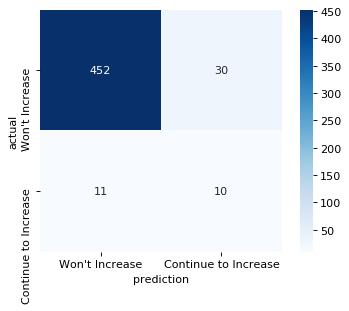

In [104]:
make_confusion_matrix(X_new, y_new, rf_pipe, 0.411, 42)

# A bit more: Exploring feature selection with Random Forest

In [105]:
# Most important features

X_new, y_new = new_df.iloc[:, 4:-1], new_df.at_risk

X_new, X_test_new, y_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2, random_state=42)

X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_new, y_new, test_size=.25, random_state=42)

In [106]:
rf_pipe.fit(X_train_new, y_train_new)

features = rf_pipe.steps[1][1].feature_importances_

feature_importance = list(zip(features, X_train_new.columns ))

In [107]:
sorted(feature_importance, reverse=True)

[(0.10850238446113902, 'pcnt_inc_wk12'),
 (0.09510895241300467, 'total_cases'),
 (0.09396070166376669, 'cases_wk_before'),
 (0.06333829784245995, 'cases_deaths'),
 (0.05607370559889921, 'tot_cases_percap'),
 (0.04913116310498371, 'county_beds'),
 (0.036697705495548356, 'population'),
 (0.036361874609914774, 'pcnt_inc_wk11'),
 (0.0285307195965537, 'ppl_popdensity'),
 (0.02714464077199392, 'tot_deaths_percap'),
 (0.026584198716875552, 'county_testing_rate'),
 (0.0234857340220085, 'county_hospitalizations'),
 (0.021841460025566067, 'ppl_hisp_pct'),
 (0.02044238552851863, 'ppl_bl_pct'),
 (0.01731496129161343, 'pcnt_inc_wk10'),
 (0.01665322111516875, 'jobs_const'),
 (0.015810989850540188, 'South'),
 (0.015467521372827177, 'inc_pov_rate'),
 (0.015418187756326768, 'jobs_agro'),
 (0.014631684761112141, 'ppl_ov65_pct'),
 (0.0144825158022431, 'ppl_wht_pct'),
 (0.014402660586962868, 'days_since_death1'),
 (0.01423952752205865, 'jobs_trans'),
 (0.014236972418444283, 'ppl_non_wht'),
 (0.01389492117

In [108]:
rf_steps = [('smote', SMOTE(random_state=42)), 
            ('model', RandomForestClassifier(class_weight='balanced_subsample', max_features='auto', 
                                             n_estimators=100))]

rf_pipe = Pipeline(rf_steps)


In [109]:
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train_new,y_train_new)

rfm_fe = SelectFromModel(RandomForestClassifier(class_weight='balanced_subsample', max_features='auto', 
                                             n_estimators=100))

rfm_fe.fit(X_smoted, y_smoted)

rfm_fe.get_support()

selected_feat= X_train_new.columns[(rfm_fe.get_support())]

selected_feat

Index(['population', 'ppl_popdensity', 'county_beds', 'total_cases',
       'tot_cases_percap', 'county_testing_rate', 'cases_wk_before',
       'pcnt_inc_wk11', 'pcnt_inc_wk12', 'ppl_hisp_pct', 'cases_deaths'],
      dtype='object')

In [110]:
best_features_df = new_df[['ppl_popdensity', 'cases_wk_before', 'pcnt_inc_wk12', 'tot_deaths_percap',
                           'tot_cases_percap', 'county_testing_rate', 'ppl_hisp_pct', 'ppl_bl_pct', 
                            'county_hospitalizations', 'at_risk']]

In [111]:
rf_cv = RandomForestClassifier(class_weight='balanced_subsample', max_features='auto', n_estimators=100)

In [112]:
X, y = best_features_df.iloc[:, 4:-1], best_features_df.at_risk

In [114]:
cv_sampling(X, y, best_models, 10, SMOTE(random_state=42))

Logistic
f1 0.16948713654288378
ROC AUC 0.7897963069087789
SVC Linear
f1 0.1606324107631371
ROC AUC 0.7806911859536039
SVC rbf
f1 0.20118472217709787
ROC AUC 0.8219505326828187
Random Forest
f1 0.2179534314184334
ROC AUC 0.8180259671135641


Reducing the number of features to only the "best" ones does not improve the model.

# Data for Tableau visualization

In [136]:
X, y = new_df.iloc[:, 4:-1], new_df.at_risk

In [137]:
rf_pipe.fit(X, y)

new_df['Risk Level'] = rf_pipe.predict_proba(X)[:,1]


In [138]:
new_df['Risk Level'] = new_df['Risk Level']*100

In [140]:
new_df.to_csv('viz_data.csv')

# Mini model to pickle

In [54]:
new_df.groupby('at_risk').mean()

,countyfips,Northeast,Other,South,West,coastal,population,ppl_popdensity,county_beds,total_cases,total_deaths,tot_cases_percap,tot_deaths_percap,days_since_case1,days_since_death1,county_hospitalizations,county_testing_rate,cases_wk_before,deaths_wk_before,pcnt_inc_wk10,pcnt_inc_wk11,pcnt_inc_wk12,inc_pov_rate,inc_med_hh,inc_per_cap,jobs_serv,jobs_manu,jobs_agro,jobs_unem,jobs_const,jobs_trans,ppl_ov65_pct,ppl_un18_pct,ppl_nohs_pct,ppl_college_pct,ppl_wht_pct,ppl_hisp_pct,ppl_bl_pct,ppl_non_wht,pct_at_risk_group,cases_deaths,cases_per_day
at_risk,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,30530.827655,0.071783,0.010916,0.445253,0.189547,0.171684,92405.876613,233.768353,226.691697,184.682765,8.359907,70.800529,2.900099,18.910685,4.843864,5.404921,0.112869,59.020840,3.893483,2.431355,1.307339,0.653685,15.422792,50768.109825,25906.882898,42.691234,12.283216,5.260782,4.135428,7.273633,5.527851,12.396001,23.403540,13.851571,20.954353,78.691274,8.187244,8.484433,21.308726,29.067678,193.042673,3.630255
1,26743.466102,0.237288,0.000000,0.406780,0.144068,0.237288,414376.881356,910.672373,926.330508,591.872881,22.288136,177.135593,6.940678,30.796610,14.677966,7.981410,0.011802,250.745763,11.186441,4.883353,1.941357,0.985036,14.236441,59350.483051,29271.262712,47.294797,12.625072,1.459310,4.079661,6.135296,4.995810,10.650547,24.044576,12.729013,27.728777,68.599576,10.866695,15.496780,31.400424,37.014021,614.161017,6.549314


In [68]:
mini_df = new_df[['ppl_popdensity', 'total_cases', 'total_deaths', 'cases_wk_before', 'days_since_case1',
                   'inc_med_hh', 'ppl_bl_pct', 'ppl_hisp_pct',  'at_risk']]

In [69]:
mini_df.groupby('at_risk').mean().head()

,ppl_popdensity,total_cases,total_deaths,cases_wk_before,days_since_case1,inc_med_hh,ppl_bl_pct,ppl_hisp_pct
at_risk,,,,,,,,
0,233.768353,184.682765,8.359907,59.020840,18.910685,50768.109825,8.484433,8.187244
1,910.672373,591.872881,22.288136,250.745763,30.796610,59350.483051,15.496780,10.866695


In [164]:
X_mini, y_mini = mini_df.drop('at_risk', axis=1), mini_df.at_risk

In [165]:
rf_pipe.fit(X_mini, y_mini)

Pipeline(memory=None,
         steps=[('under_sample',
                 RandomUnderSampler(random_state=None, replacement=False,
                                    sampling_strategy='auto')),
                ('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=120, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose

In [166]:
fn = 'rf_model.sav'

In [167]:
pickle.dump(rf_pipe, open(fn, 'wb'))